In [1]:
import io
import sys
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen

In [2]:
URL = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"

df_full = pd.read_csv(URL)
cols = [
    "engine_displacement",
    "horsepower",
    "vehicle_weight",
    "model_year",
    "fuel_efficiency_mpg",
]
df = df_full[cols].copy()

print(df.shape)
df.head()

(9704, 5)


,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


Skewness: -0.012062219273507922


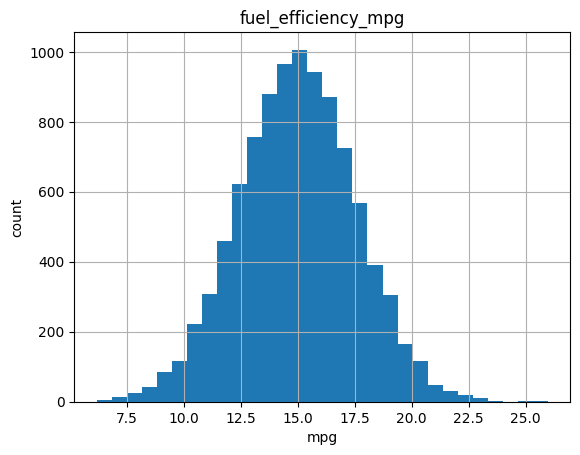

In [3]:
target = "fuel_efficiency_mpg"

print("Skewness:", df[target].skew())
ax = df[target].hist(bins=30)
ax.set_title("fuel_efficiency_mpg")
ax.set_xlabel("mpg")
ax.set_ylabel("count")
plt.show()

In [5]:
# Q1
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts)

col_with_na = na_counts[na_counts > 0].index[0] if (na_counts > 0).any() else None
print("Q1 — Column with missing values:", col_with_na)

horsepower             708
engine_displacement      0
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

Q1 — Column with missing values: horsepower


In [6]:
# Q2
median_hp = float(df["horsepower"].median())
print("Q2 — Median horsepower:", median_hp)

Q2 — Median horsepower: 149.0


In [7]:
def split_train_val_test(dataframe, seed=42):
    n = len(dataframe)
    rng = np.random.RandomState(seed)
    idx = np.arange(n)
    rng.shuffle(idx)

    n_train = int(0.6 * n)
    n_val = int(0.2 * n)
    n_test = n - n_train - n_val

    idx_train = idx[:n_train]
    idx_val = idx[n_train:n_train + n_val]
    idx_test = idx[n_train + n_val:]

    return (
        dataframe.iloc[idx_train].copy(),
        dataframe.iloc[idx_val].copy(),
        dataframe.iloc[idx_test].copy(),
    )

df_train, df_val, df_test = split_train_val_test(df, seed=42)
len(df_train), len(df_val), len(df_test)

(5822, 1940, 1942)

In [8]:
FEATURES = ["engine_displacement", "horsepower", "vehicle_weight", "model_year"]
TARGET = "fuel_efficiency_mpg"

def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred) ** 2))

def prepare_X_y(df_in):
    X = df_in[FEATURES].values.astype(float)
    y = df_in[TARGET].values.astype(float)
    return X, y

def add_bias(X):
    # Add column of ones at the front for bias
    n = X.shape[0]
    return np.column_stack([np.ones(n), X])

def train_linear_regression(X, y, r=0.0):
    """
    Closed-form: (X^T X + r*I_)^-1 X^T y
    We do NOT regularize the bias term.
    """
    Xb = add_bias(X)
    n_features = Xb.shape[1]

    I = np.eye(n_features)
    I[0, 0] = 0.0

    A = Xb.T @ Xb + r * I
    b = Xb.T @ y
    w = np.linalg.inv(A) @ b
    return w

def predict(X, w):
    Xb = add_bias(X)
    return Xb @ w

def fit_and_eval(train_df, val_df, impute="zero", r=0.0):
    # Copy to avoid mutating inputs
    tr, va = train_df.copy(), val_df.copy()

    if impute == "zero":
        tr[FEATURES] = tr[FEATURES].fillna(0.0)
        va[FEATURES] = va[FEATURES].fillna(0.0)
    elif impute == "train_mean":
        means = tr[FEATURES].mean()
        tr[FEATURES] = tr[FEATURES].fillna(means)
        # IMPORTANT: use train means for val
        va[FEATURES] = va[FEATURES].fillna(means)
    else:
        raise ValueError("impute must be 'zero' or 'train_mean'")

    X_tr, y_tr = prepare_X_y(tr)
    X_va, y_va = prepare_X_y(va)

    w = train_linear_regression(X_tr, y_tr, r=r)
    y_pred = predict(X_va, w)
    return rmse(y_va, y_pred), w

In [9]:
# Q3
df_train, df_val, df_test = split_train_val_test(df, seed=42)

rmse_zero, _ = fit_and_eval(df_train, df_val, impute="zero", r=0.0)
rmse_mean, _ = fit_and_eval(df_train, df_val, impute="train_mean", r=0.0)

print("RMSE (fill 0):   ", round(rmse_zero, 2))
print("RMSE (fill mean):", round(rmse_mean, 2))

if round(rmse_zero, 2) < round(rmse_mean, 2):
    q3_answer = "With 0"
elif round(rmse_zero, 2) > round(rmse_mean, 2):
    q3_answer = "With mean"
else:
    q3_answer = "Both are equally good"
print("Q3 — Best option:", q3_answer)


RMSE (fill 0):    0.52
RMSE (fill mean): 0.46
Q3 — Best option: With mean


In [10]:
# Q4
R_LIST = [0, 0.01, 0.1, 1, 5, 10, 100]

scores = {}
for r in R_LIST:
    score, _ = fit_and_eval(df_train, df_val, impute="zero", r=r)
    scores[r] = round(score, 2)

scores_sorted = dict(sorted(scores.items(), key=lambda kv: kv[0]))
scores_sorted


{0: np.float64(0.52),
 0.01: np.float64(0.52),
 0.1: np.float64(0.52),
 1: np.float64(0.52),
 5: np.float64(0.52),
 10: np.float64(0.52),
 100: np.float64(0.52)}

In [11]:
# Pick best r
best_r = None
best_rmse = float("inf")

for r, sc in scores.items():
    if sc < best_rmse or (math.isclose(sc, best_rmse) and (best_r is None or r < best_r)):
        best_rmse = sc
        best_r = r

print("Validation RMSE by r (rounded):", scores_sorted)
print("Q4 — Best r:", best_r)


Validation RMSE by r (rounded): {0: np.float64(0.52), 0.01: np.float64(0.52), 0.1: np.float64(0.52), 1: np.float64(0.52), 5: np.float64(0.52), 10: np.float64(0.52), 100: np.float64(0.52)}
Q4 — Best r: 0


In [12]:
# Q5
seed_scores = []

for seed in range(10):
    tr, va, te = split_train_val_test(df, seed=seed)
    score, _ = fit_and_eval(tr, va, impute="zero", r=0.0)
    seed_scores.append(score)

seed_scores = np.array(seed_scores, dtype=float)
std_scores = float(np.std(seed_scores))
print("Validation RMSEs:", [round(s, 3) for s in seed_scores])
print("Std of RMSEs:", round(std_scores, 3))

Validation RMSEs: [np.float64(0.521), np.float64(0.522), np.float64(0.523), np.float64(0.516), np.float64(0.511), np.float64(0.529), np.float64(0.532), np.float64(0.51), np.float64(0.515), np.float64(0.513)]
Std of RMSEs: 0.007


In [13]:
# Q6
tr, va, te = split_train_val_test(df, seed=9)

# combine train + val
tr_full = pd.concat([tr, va], ignore_index=True)

# train with r = 0.001 (tiny regularization)
score_test, w = fit_and_eval(tr_full, te, impute="zero", r=0.001)
print("Q6 — Test RMSE:", round(score_test, 3))


Q6 — Test RMSE: 0.515
